In [4]:
import numpy as np
from photutils.segmentation import SourceFinder
import matplotlib.pyplot as plt
from astropy.io import fits

Min value: 0.06382978707551956
Max value: 12378.0693359375
Mean value: 0.3133542112639433


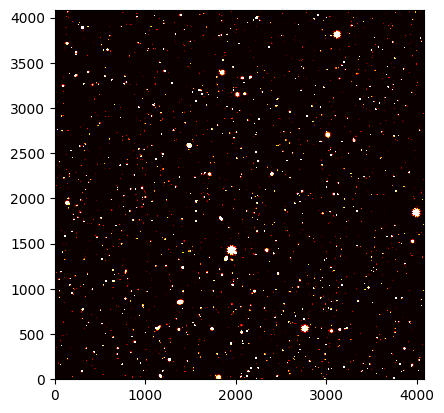

In [5]:
direct_fits = fits.open("/Users/keith/astr/research_astr/FOV0/GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits")
direct, header = (direct_fits[1].data, direct_fits[1].header)
plt.imshow(direct, vmin=0.4, vmax=1., cmap='hot', origin='lower')

# Simple stats
print("Min value: %s" % direct.min())
print("Max value: %s" % direct.max())
print("Mean value: %s" % direct.mean())

Background min: 0.24822695553302765
Background max: 0.25531914830207825
Background mean: 0.24846228283501404


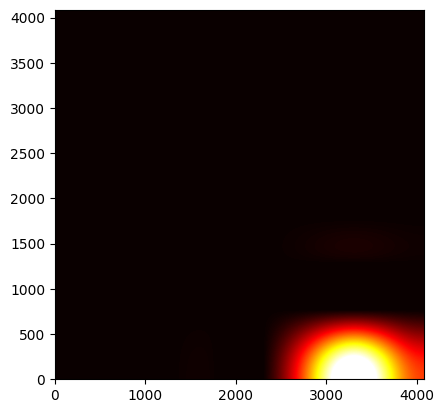

In [6]:
# Measure Background
from photutils.background import Background2D, MedianBackground
bkg_estimator = MedianBackground()

# direct.shape is (4088, 4088); Larger objects are 30+ pixels; 
# box_size (511, 511) selected as a multiple of 4088 much larger that 30 pixels
# Other box_sizes have background estimates heavily biased by the local large objects
bkg = Background2D(direct, (511,511), filter_size=(3,3), bkg_estimator=bkg_estimator)
plt.imshow(bkg.background, origin='lower', cmap='hot')

# Check background is close to 0.25
print("Background min: %s" % bkg.background.min())
print("Background max: %s" % bkg.background.max())
print("Background mean: %s" % bkg.background.mean())

Min value: -0.18439740557495202
Max value: 12377.821108981967
Mean value: 0.06489192842892925


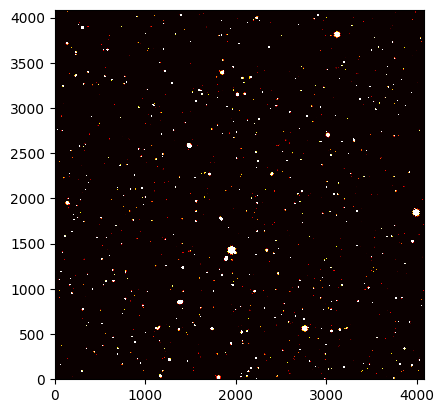

In [7]:
# Subtract Background
direct -= bkg.background
plt.imshow(direct, vmin=0.4, vmax=1., cmap='hot', origin='lower')

# Simple stats post-background subtraction
print("Min value: %s" % direct.min())
print("Max value: %s" % direct.max())
print("Mean value: %s" % direct.mean())

In [8]:
# Determine a threshold value
threshold = 2 * bkg.background_rms

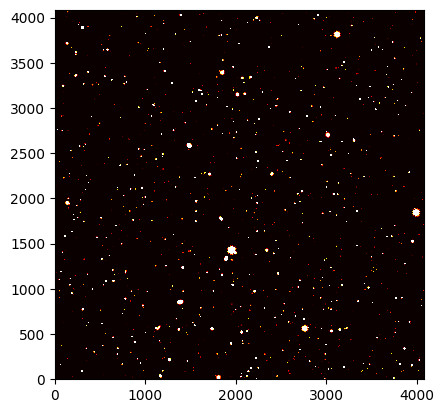

In [9]:
# Convolve data
from astropy.convolution import convolve
from photutils.segmentation import make_2dgaussian_kernel
kernel = make_2dgaussian_kernel(3.0, 5)
convolved_data = convolve(direct, kernel)
plt.imshow(convolved_data, vmin=0.3, vmax=1., cmap='hot', origin='lower')

In [10]:
# Instantiate the SourceFinder
finder = SourceFinder(npixels=7, nlevels=32, contrast=0.001)

Deblending:   0%|          | 0/6281 [00:00<?, ?it/s]

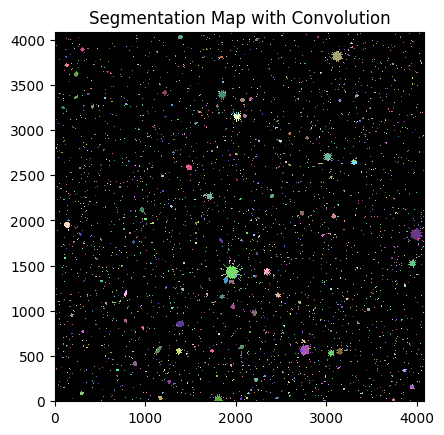

In [11]:
convolved_seg_map = finder(convolved_data, threshold)
plt.imshow(convolved_seg_map, cmap=convolved_seg_map.cmap, interpolation='nearest', origin='lower')
plt.title("Segmentation Map with Convolution");

## Moving forward with the convolved seg map

In [12]:
from photutils.segmentation import SourceCatalog
cat = SourceCatalog(direct, convolved_seg_map, convolved_data=convolved_data)
tbl = cat.to_table()
tbl['xcentroid'].info.format = '.2f'  # optional format
tbl['ycentroid'].info.format = '.2f'
tbl['kron_flux'].info.format = '.2f'
print(tbl)
print(tbl[0]['area'].value)

label xcentroid ycentroid ... segment_fluxerr kron_flux kron_fluxerr
                          ...                                       
----- --------- --------- ... --------------- --------- ------------
    1    453.00      3.23 ...             nan     24.98          nan
    2    673.57      1.39 ...             nan      4.88          nan
    3   2206.35      2.81 ...             nan      5.73          nan
    4   2226.57      6.76 ...             nan    176.57          nan
    5   2284.87      1.85 ...             nan     62.68          nan
    6   2294.91      1.40 ...             nan     22.27          nan
    7   2981.74      3.07 ...             nan    196.24          nan
    8   3122.50      0.76 ...             nan      2.51          nan
    9   3566.40      2.03 ...             nan      9.40          nan
   10   3588.38      1.35 ...             nan      3.09          nan
  ...       ...       ... ...             ...       ...          ...
 7670   1367.61   4001.77 ...     

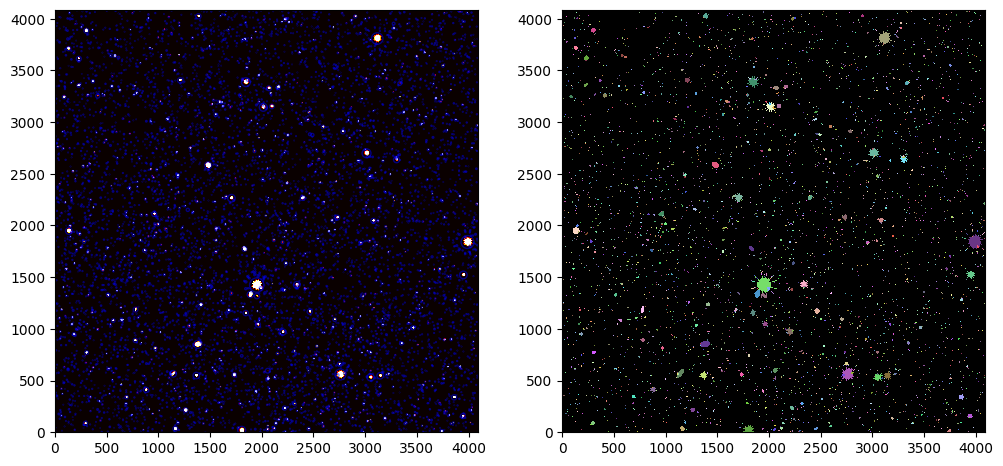

In [13]:
import matplotlib.patches as pch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 12))

ax1.imshow(direct, vmin=0.4, vmax=1., cmap='hot', origin='lower')
for object in tbl:
    patch = pch.Circle((object['xcentroid'], object['ycentroid']), fill=False, radius=np.sqrt(object['area'].value/np.pi), alpha=0.5, color='blue')
    ax1.add_patch(patch)


ax2.imshow(convolved_seg_map, cmap=convolved_seg_map.cmap, interpolation='nearest', origin='lower')

In [14]:
# Read in simulation object table and set real/found_object variables
from astropy.io import ascii

converters = {'col1': np.float32,
              'col2': np.float32}
real_objects = ascii.read("/Users/keith/astr/research_astr/FOV0/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt",
                          converters=converters).as_array()

found_objects = tbl.as_array()

In [16]:
realcatandkeys = (real_objects, "NUMBER", "X_IMAGE", "Y_IMAGE")
foundcatandkeys = (found_objects, "label", "xcentroid", "ycentroid")

In [17]:
# pass in tuple of catalog and key
def catalog_match(catandkeys1, catandkeys2):
    cat1, id1, x1, y1 = catandkeys1
    cat2, id2, x2, y2 = catandkeys2
    closest_matches = []

    for object in cat1:
        x, y = object[x1], object[y1]
        distances = np.sqrt((cat2[x2] - x)**2 + (cat2[y2] - y)**2)
        closest_matches.append(cat2[np.argmin(distances)])
    
    return closest_matches


In [18]:
catalog_match(foundcatandkeys, realcatandkeys)

[(50062, 453.9917, 4.0997, 2.0978, 1.3697, 10.63, 23.02, 50062, 0.797619, 0, 9.5073271, -0.800097),
 (182433, 674.5997, 2.2713, 0.6521, 0.5023, 291.77, 24.92, 182433, 2.433581, 0, 9.5005673, -0.8001187),
 (138104, 2207.3507, 3.7312, 1.3724, 1.3567, 327.84, 24.66, 138104, 2.631368, 0, 9.4536323, -0.7998832),
 (63949, 2227.5119, 7.6775, 3.1602, 2.6354, 153.31, 20.93, 63949, 0.91206, 0, 9.4530149, -0.7997578),
 (97979, 2285.9058, 2.4493, 1.5032, 1.3877, 255.96, 21.98, 97979, 2.44571, 0, 9.4512282, -0.7999164),
 (97974, 2295.8627, 1.7753, 1.2521, 0.3867, 351.31, 23.05, 97974, 2.4456, 0, 9.4509235, -0.7999366),
 (199024, 2982.6415, 3.6139, 8., 8., 0., 20.5, 197363, 0., 1, -1000., -1000.),
 (119731, 3123.6484, 0.4513, 1.5409, 1.4784, 61.4, 24.65, 119731, 1.829992, 0, 9.4255941, -0.7999201),
 (7335, 3567.34, 2.7654, 1.6429, 1.2963, 130.98, 23.93, 7335, 1.880053, 0, 9.4120203, -0.7998285),
 (69769, 3589.3694, 2.3323, 0.6778, 0.2655, 144.29, 25.28, 69769, 2.196743, 0, 9.4113464, -0.7998413),
 (